In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys
import warnings
import gc
import random
import numpy as np
random.seed(1801)
np.random.seed(1801)
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.color import rgb2gray
from skimage.morphology import label
from scipy import ndimage as ndi
import zipfile

from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, Add, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Activation, ZeroPadding2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

# Set some parameters
BS = 40
EPOCHS= 200
ORI_D = 101
INP_D = 128
PAD = INP_D-ORI_D
PAD_1 = PAD//2
PAD_2 = PAD-PAD_1
TRAIN_ZIP = '../input/train.zip'
TEST_ZIP = '../input/test.zip'
TRAIN_PATH = '../input/train/'
TEST_PATH = '../input/test/'
TRAIN_CSV = '../input/train.csv'
DEPTH_CSV = '../input/depths.csv'

if not os.path.exists(TRAIN_PATH):
    zip_ref = zipfile.ZipFile(TRAIN_ZIP, 'r')
    zip_ref.extractall(TRAIN_PATH)
    zip_ref.close()
if not os.path.exists(TEST_PATH):
    zip_ref = zipfile.ZipFile(TEST_ZIP, 'r')
    zip_ref.extractall(TEST_PATH)
    zip_ref.close()
if not os.path.exists('./models'):
    os.makedirs('./models')
print(os.listdir(TRAIN_PATH))

/home/peter/anaconda3/envs/dnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['images', 'masks']


In [2]:
def rle_encoding(x, order='F', to_str=True):
    dots = np.where(x.flatten(order=order) == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    if to_str:
        return ' '.join(str(y) for y in run_lengths)
    return run_lengths


In [3]:
train_csv = pd.read_csv(TRAIN_CSV)
depth_csv = pd.read_csv(DEPTH_CSV)
test_csv = depth_csv[~depth_csv.index.isin(train_csv.index)]
del depth_csv
gc.collect()

7

In [4]:
X_train = []
Y_train = [] 

print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_csv.id), total=len(train_csv.id)):
    path = TRAIN_PATH
    img = imread(path + 'images/' + id_ + '.png')[...,0].astype(np.uint8)
    assert img.ndim==2
    assert img.shape[0]==ORI_D and img.shape[1]==ORI_D
    X_train.append(img)
    mask = np.squeeze(imread(path + 'masks/' + id_ + '.png')>0).astype(np.uint8)
    assert mask.ndim==2
    Y_train.append(mask)
del img, mask
gc.collect()

Getting train images and masks ... 


100%|██████████| 4000/4000 [00:02<00:00, 1616.44it/s]


0

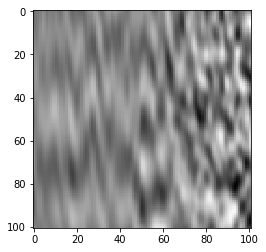

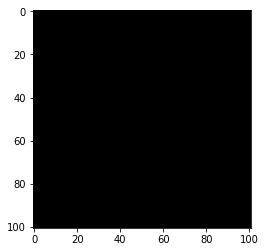

In [5]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_csv.id))
plt.imshow(X_train[ix], cmap='gray')
plt.show()
plt.imshow(Y_train[ix], cmap='gray')
plt.show()

In [6]:
# Define IoU metric
def score_numpy(Ys, Ps, th=0.45):
    iou_ths = np.arange(0.0, 1.0, 0.05)
    Ps = Ps.reshape(Ps.shape[0], -1).copy()
    Ys = Ys.reshape(Ys.shape[0], -1).copy()
    for n, P in enumerate(Ps):
        Ps[n] = P>th
    Ps = Ps.astype(np.bool)
    Ys = Ys.astype(np.bool)
    TPs = np.zeros_like(iou_ths, dtype=np.float32)
    FPs = np.zeros_like(iou_ths, dtype=np.float32)
    FNs = np.zeros_like(iou_ths, dtype=np.float32)
    for Y, P in zip(Ys, Ps):
        iou = (Y&P).sum() / ((Y|P).sum()+1e-9)
        Y_sum = Y.sum()
        P_sum = P.sum()
        for n, iou_th in enumerate(iou_ths):
            if iou>=iou_th: # TP
                TPs[n]+=1
            elif Y_sum<=0 and P_sum>0: # FP
                FPs[n]+=1
            elif Y_sum>0 and P_sum<=0: # FN
                FNs[n]+=1
    return np.mean(TPs / (TPs+FPs+FNs))

def score(label, pred):
    metric_value = tf.py_func(score_numpy, [label, pred], tf.float32)
    return metric_value
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=None) # scaler

def custom_loss(y_true, y_pred):
    
    def dice_coef(y_true, y_pred): 
        return (2.* K.sum(y_true*y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1) # scaler
    
    s_dice_coef = dice_coef(y_true, y_pred) # scaler
    s_bce = K.mean(K.binary_crossentropy(y_true, y_pred)) # scaler
    loss = 0.5*s_bce - s_dice_coef + 1. # scaler [0, inf)
    
    loss = tf.Print(loss, [s_dice_coef], message='\ns_dice_coef:\t', summarize=10)
    loss = tf.Print(loss, [s_bce], message='\ns_bce:\t', summarize=10)
    
    return loss # scaler [0, inf)

In [7]:
def build_model():
    def conv(f, k=3, act='relu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _res_conv(inputs, f, k=3): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = inputs
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        cs = Dropout(0.2) (cs)
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        if f!=channels:
            t1 = conv(f, 1, None) (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(inputs):
        #def bilinear(x):
        #    return tf.image.resize_bilinear(x, (K.int_shape(x)[-3]*2, K.int_shape(x)[-2]*2), align_corners=True)
        upsampled = Conv2DTranspose(int(inputs.shape[-1]), (2, 2), strides=(2, 2), padding='same') (inputs)
        #upsampled = Lambda(bilinear) (inputs)
        return upsampled
    
    inputs = Input(shape=(ORI_D, ORI_D, 1))
    preprocess1 = Lambda(lambda x: x / 255.0) (inputs)
    pad1 = ZeroPadding2D(((PAD_1, PAD_2), (PAD_1, PAD_2))) (preprocess1)
    
    r = 16
    rep = 5 # 5*2*2*2 = 40
    mid_rep = 5 # 5*2 = 10 => 50+ layers resnet
    x = pad1
    
    skip_connections = []
    
    x = conv(r, 3, act='relu') (x)
    x = _res_conv(x, r, 3)
    skip_connections.append(x)
    x = pool() (x)
    
    for t in range(1, rep):
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
        skip_connections.append(x)
        x = pool() (x)
    
    for t in range(mid_rep):
        x = _res_conv(x, r*int(2**5))
    
    for t, s in zip(reversed(range(rep)), reversed(skip_connections)):
        x = up(x)
        x = concatenate([x, s])
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs_crop = Lambda(lambda x: x[:,PAD_1:-PAD_2,PAD_1:-PAD_2,:], name='align') (outputs)
    return Model([inputs], [outputs_crop])

In [8]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_norm

In [9]:
from keras.utils import Sequence
import cv2
from sklearn.utils import shuffle
from skimage.transform import AffineTransform, warp
import copy
import imgaug as ia
from imgaug import augmenters as iaa

class data_generator(Sequence):
    def __init__(self, data, label, batch_size=4, training=True):
        self.data = data
        self.label= label
        self.batch_size = batch_size
        self.training = training
        self.seq_color = iaa.Sequential(
            [
                iaa.SomeOf((0, 2),
                    [
                        iaa.Dropout((0.01, 0.1)),
                        iaa.ContrastNormalization((0.5, 1.5)),
                        
                    ], random_order=True
                )
            ], random_order=True
        )
    def __len__(self):
        return int(np.ceil(float(len(self.data))/self.batch_size))
    def on_epoch_end(self):
        if self.training: self.data, self.label = shuffle(self.data, self.label)
    def __getitem__(self, i):
        l_bound =  i    * self.batch_size
        r_bound = (i+1) * self.batch_size
        if r_bound>len(self.data): # ensure every iteration has the same batch size
            r_bound = len(self.data)
            l_bound = r_bound - self.batch_size
        dat_que = np.empty((self.batch_size, ORI_D, ORI_D, 1), dtype=np.uint8)
        lab_que = np.empty((self.batch_size, ORI_D, ORI_D, 1), dtype=np.uint8)
        for n, index in enumerate(range(l_bound, r_bound)):
            img = copy.deepcopy(self.data[index]).astype(np.float32) / 255.
            lab = copy.deepcopy(self.label[index]).astype(np.float32)
            if self.training:
                if np.random.rand() < .5: # flip horizontal
                    img = np.flip(img, 1)
                    lab = np.flip(lab, 1)

                # random amplify each channel
                a = .05 # amptitude
                t  = np.random.uniform(1-a,1+a)
                img = np.clip(img * t, 0, 1) # channel wise amplify
                
                if np.random.rand()<0.5:
                    up = np.random.uniform(0.95, 1.05) # change gamma
                    img = np.clip(img**up, 0, 1) # apply gamma and convert back to range [0,255]
                
                sigma = np.random.rand()*0.03
                img = np.clip(img + np.random.randn(*img.shape)*sigma, 0, 1)
                
                '''
                if np.random.rand() < 0.3:
                    angle = np.random.uniform(-8,8)
                    cx = int(img.shape[1]//2)
                    cy = int(img.shape[0]//2)
                    M = cv2.getRotationMatrix2D((cx,cy),angle,1)
                    cos = np.abs(M[0, 0])
                    sin = np.abs(M[0, 1])
                    (h, w) = img.shape[:2]
                    # compute the new bounding dimensions of the image
                    nW = int((h * sin) + (w * cos))
                    nH = int((h * cos) + (w * sin))
                    # adjust the rotation matrix to take into account translation
                    M[0, 2] += (nW / 2) - cx
                    M[1, 2] += (nH / 2) - cy
                    img = np.clip(cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT), 0, 1)
                    lab = np.clip(cv2.warpAffine(lab, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT), 0, 1)
                
                if np.random.rand() < 0.2:
                    det_warp = iaa.PiecewiseAffine(scale=(0.01, 0.05)).to_deterministic()
                    img = det_warp.augment_image(img)
                    lab = det_warp.augment_image(lab)
                '''
                if np.random.rand() < 0.4:
                    crop_ratio = np.random.uniform(0.01, 0.1, size=4)
                    u, r, d, l = np.round(crop_ratio * np.array([img.shape[0], img.shape[1]]*2)).astype(np.uint8)
                    img = img[u:-d,l:-r] # crop image
                    lab = lab[u:-d,l:-r] # crop image
                
                if np.random.rand() < 0.2:
                    img = np.clip(self.seq_color.augment_image(img), 0, 1)
            
                if np.random.rand() < 0.2:
                    ksize = np.random.choice([3,5])
                    img = cv2.GaussianBlur(img, (ksize,ksize), 0)
            ### end of data augmentation ###

            img = np.clip(img.astype(np.float32)*255,0, 255).astype(np.uint8)
            lab = np.round(np.clip(lab.astype(np.float32),0, 1)).astype(np.uint8)
            
            if img.shape[0]!=ORI_D or img.shape[1]!=ORI_D:
                img = cv2.resize(img, (ORI_D,ORI_D), interpolation=cv2.INTER_LINEAR)
                lab = cv2.resize(lab, (ORI_D,ORI_D), interpolation=cv2.INTER_LINEAR)

            dat_que[n,...,0] = img
            lab_que[n,...,0] = lab
        return dat_que, lab_que

In [10]:
coverage = np.asarray([ x.sum() / (ORI_D**2) for x in Y_train ])
coverage_lev = np.linspace(0, 1, 100)
import bisect
coverage_stratify = []
for cov in coverage:
    coverage_stratify.append(bisect.bisect_left(coverage_lev, cov))

In [11]:
# https://www.surveysystem.com/sscalc.htm
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=1000, shuffle=True, stratify = coverage_stratify)
del coverage, coverage_lev, coverage_stratify

In [ ]:
train_generator = data_generator(X_train, Y_train, batch_size=BS, training=True)
val_generator = data_generator(X_val, Y_val, batch_size=BS, training=False)

In [ ]:
import multiprocessing
from keras.optimizers import SGD

checkpointer_best = ModelCheckpoint('./models/best.h5', monitor='val_score', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_score', factor=0.5,
                              patience=5, min_lr=0.00001, mode='max')
model.compile(loss=custom_loss, optimizer='adam', metrics=[mean_iou, score, 'accuracy'])
history = model.fit_generator(train_generator,
                              steps_per_epoch= len(train_generator), 
                              epochs=EPOCHS, 
                              validation_data=val_generator, 
                              validation_steps= len(val_generator),
                              callbacks=[checkpointer_best, reduce_lr],
                              workers= max(1, multiprocessing.cpu_count()-3),
                              use_multiprocessing= True,
                              shuffle = True
                              )

Epoch 1/200
75/75 [==============================] - 58s 779ms/step - loss: 0.8239 - mean_iou: 0.4289 - score: 0.3356 - acc: 0.7511 - val_loss: 2.2018 - val_mean_iou: 0.5148 - val_score: 0.4169 - val_acc: 0.6348

Epoch 00001: val_score improved from -inf to 0.41690, saving model to ./models/best.h5
Epoch 2/200
75/75 [==============================] - 48s 643ms/step - loss: 0.5933 - mean_iou: 0.5440 - score: 0.4590 - acc: 0.8533 - val_loss: 0.5503 - val_mean_iou: 0.5788 - val_score: 0.5627 - val_acc: 0.8838

Epoch 00002: val_score improved from 0.41690 to 0.56269, saving model to ./models/best.h5
Epoch 3/200
75/75 [==============================] - 48s 646ms/step - loss: 0.5541 - mean_iou: 0.5982 - score: 0.5012 - acc: 0.8633 - val_loss: 0.5752 - val_mean_iou: 0.6110 - val_score: 0.4802 - val_acc: 0.8639

Epoch 00003: val_score did not improve
Epoch 4/200
75/75 [==============================] - 49s 653ms/step - loss: 0.5193 - mean_iou: 0.6189 - score: 0.5274 - acc: 0.8730 - val_loss: 0

In [ ]:
del train_generator, val_generator
gc.collect()

In [ ]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('LB')
plt.ylabel('LB @threshold=0.45')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

In [ ]:
model.load_weights('./models/best.h5')
# Predict on train, val
preds_val = model.predict(np.asarray(X_val)[...,np.newaxis], batch_size=BS, verbose=1)

In [ ]:
### compute validation mAP

threshold_choices = np.arange(0.1, 1.0, 0.01)
iou_ths = np.arange(0.5, 1.0, 0.05)
best_threshold = 0.1
best_score = 0

for th in threshold_choices:
    Ys = np.squeeze(Y_val)
    Ps = np.squeeze(preds_val)
    score = score_numpy(Ys, Ps, th)
    print('score: {:.4f} @threshold: {:.2f}'.format(score, th))
    if score>best_score:
        best_score = score
        best_threshold = th
print('best threshold: {:.2f}, mAP: {:.8f}'.format(best_threshold, best_score))


In [ ]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_val))
print(ix)
shape = Y_val[ix].shape[:2]
plt.imshow(X_val[ix])
plt.show()
plt.imshow(Y_val[ix])
plt.show()
preds = np.squeeze(preds_val[ix])
preds = preds>best_threshold
plt.imshow(preds)
plt.show()

In [ ]:
del X_train, Y_train, X_val, Y_val, preds_val
gc.collect()

In [ ]:
sub_rles = []
x_test = []
print('Reading testing data...')
for n, id_ in tqdm(enumerate(test_csv.id), total=len(test_csv.id)):
    path = TEST_PATH
    img = imread(path + 'images/' + id_ + '.png')[...,0].astype(np.uint8)[...,np.newaxis]
    x_test.append(img)

print('Predicting...')
preds = model.predict(np.asarray(x_test), batch_size=BS, verbose=1)[...,0]
print('Convert to RLE...')
for pred in tqdm(preds, total=len(preds)):
    pred_thresholded = (pred>best_threshold).astype(np.bool)
    rle = rle_encoding(pred_thresholded)
    sub_rles.append(rle)
sub = pd.DataFrame()
sub['id'] = test_csv.id
sub['rle_mask'] = sub_rles
sub.to_csv('salty.csv', index=False)
print('Done!')